In [6]:
from cryosparc.tools import CryoSPARC
import json
from pathlib import Path
from collections import Counter

with open(Path('~/instance-info.json').expanduser(), 'r') as f:
    instance_info = json.load(f)

cs = CryoSPARC(**instance_info)
assert cs.test_connection()

project_number = "P294"
workspace_number = "W3"
job_number = "J77"
# change this for other job types
output_name = "split_0"

project = cs.find_project(project_number)
job = project.find_job(job_number)
results = job.load_output(output_name)

Connection succeeded to CryoSPARC command_core at http://cryoem0.sbi:40002
Connection succeeded to CryoSPARC command_vis at http://cryoem0.sbi:40003
Connection succeeded to CryoSPARC command_rtp at http://cryoem0.sbi:40005


In [13]:
counted_src_uids = Counter(results['sym_expand/src_uid'])
highest_count = counted_src_uids.most_common(1)[0][1]

In [15]:
def count_threshold(threshold):
    filtered_src_uids = [
        src_uid
        for src_uid, count in counted_src_uids.items()
        if count == threshold
    ]
    filtered_dataset = results.query({
        "sym_expand/src_uid": filtered_src_uids
    })
    return filtered_dataset

thresholded_datasets = {}
for thresh in range(1, highest_count + 1):
    thresholded_datasets[thresh] = count_threshold(thresh)

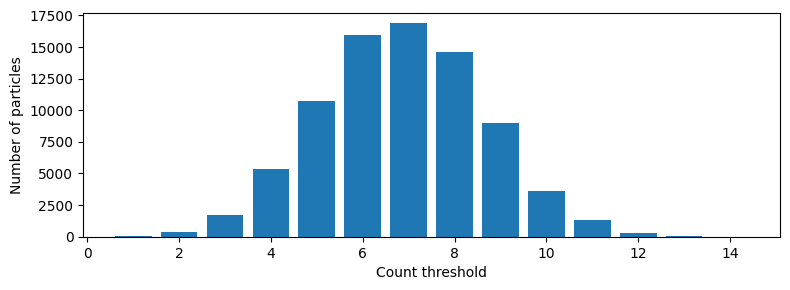

In [16]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (8, 3))
ax.bar(
    thresholded_datasets.keys(),
    [len(x) for x in thresholded_datasets.values()]
)
ax.set_ylabel('Number of particles')
ax.set_xlabel('Count threshold')
fig.tight_layout()

In [5]:
out_job = project.create_external_job(
    workspace_uid=workspace_number,
    title=f"Threshold particle counts",
    desc="Each output contains particles with at least N copies in input. Outputs are *not* disjoint."
)
out_job.add_input(
    type = "particle",
    name = "input_particles"
)
out_job.connect(
    target_input = "input_particles",
    source_job_uid = job_number,
    source_output = output_name
)

for thresh, dset in thresholded_datasets.items():
    output = out_job.add_output(
        type = "particle",
        name = f"threshold_{thresh}",
        passthrough = "input_particles",
        slots = ["blob"],
        alloc = dset
    )
    out_job.save_output(f"threshold_{thresh}", dset)

out_job.log_plot(fig, "Histogram of particles retained at each threshold.")
out_job.stop()